In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
DATA_DIR = 'datasets/ml-data/'

In [3]:
df = pd.read_csv(DATA_DIR + 'ratings.csv')

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [20]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', '8G')
    .config('spark.sql.analyzer.failAmbiguousSelfJoin', 'False')
    .master("local[*]")
    .getOrCreate()
)

In [6]:
# считываем данные из CSV
# и преобразуем времяпроставления оценки из целого числа в дату мл временем
import os
import pyspark.sql.functions as sql_func

ratings = (
    spark
    .read
    .csv(
        os.path.join(DATA_DIR, 'ratings.csv'),
        header=True,
        inferSchema=True
    )
    # если используется меньше памяти,
    # то здесь можно взять не все данные, а небольшую выборку
    # даже при fraction=.01 качественная картина не меняеся
    .sample(withReplacement=False, fraction=1.0, seed=0)
    .withColumn('rating_datetime', sql_func.from_unixtime('timestamp'))
    .drop('timestamp')
    .cache()
)

In [7]:
ratings.show()

+------+-------+------+-------------------+
|userId|movieId|rating|    rating_datetime|
+------+-------+------+-------------------+
|     1|    307|   3.5|2009-10-28 00:00:21|
|     1|    481|   3.5|2009-10-28 00:04:16|
|     1|   1091|   1.5|2009-10-28 00:04:31|
|     1|   1257|   4.5|2009-10-28 00:04:20|
|     1|   1449|   4.5|2009-10-28 00:01:04|
|     1|   1590|   2.5|2009-10-28 00:00:36|
|     1|   1591|   1.5|2009-10-28 00:04:35|
|     1|   2134|   4.5|2009-10-28 00:04:24|
|     1|   2478|   4.0|2009-10-28 00:00:39|
|     1|   2840|   3.0|2009-10-28 00:05:00|
|     1|   2986|   2.5|2009-10-28 00:04:56|
|     1|   3020|   4.0|2009-10-28 00:01:00|
|     1|   3424|   4.5|2009-10-28 00:04:04|
|     1|   3698|   3.5|2009-10-28 00:00:43|
|     1|   3826|   2.0|2009-10-28 00:00:10|
|     1|   3893|   3.5|2009-10-28 00:04:46|
|     2|    170|   3.5|2007-10-21 00:53:01|
|     2|    849|   3.5|2007-10-21 00:52:17|
|     2|   1186|   3.5|2007-10-21 00:53:31|
|     2|   1235|   3.0|2007-10-2

In [8]:
# оцениваем размеры данных
print('всего пользователей', ratings.select('userId').distinct().count())
print('всего фильмов', ratings.select('movieId').distinct().count())
print('всего оценок', ratings.count())

всего пользователей 283228
всего фильмов 53889
всего оценок 27753444


In [9]:
# достаточно хорошим baseline является пердсказать среднюю оценку
mean_rating = ratings.agg(sql_func.avg('rating')).first()[0]
print('Средняя оценка:', mean_rating)

Средняя оценка: 3.5304452124932677


In [10]:
# Функция, с помощью которой мы будем вычислять RMSE на обучающей выборке
from pyspark.sql import DataFrame
import numpy as np

def simple_evaluate(predictions_df: DataFrame) -> float:
    return np.sqrt(
        ratings
        .join(
            predictions_df,
            ['movieId', 'userId']
        ).select(
            sql_func.pow(
                ratings.rating - predictions_df.prediction,
                2
            ).alias('squared_error')
        )
        .agg(sql_func.avg('squared_error'))
        .first()[0]
    )

In [11]:
# рекомендуем любому пользователю любой фильм случайно
mean_predictions = ratings.withColumn('prediction', sql_func.lit(mean_rating))
print('Ошибка предсказания:', simple_evaluate(mean_predictions))

Ошибка предсказания: 1.0663527310206389


In [12]:
# посмотрим на распределение срудних оценок фильмов
movie_ratings = (
    ratings
    .groupBy('movieId')
    .agg(sql_func.avg('rating').alias('avg_movie_rating'))
    .cache()
)

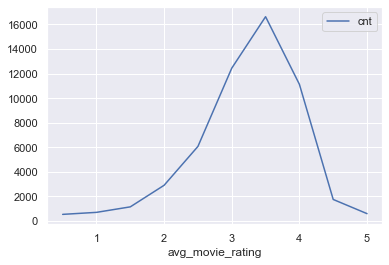

In [13]:
# фильм бывает более или менее популярным - выбросы есть в обе стороны,
# но "средних" фильмов все-таки большинство
histogram = (
    movie_ratings
    .select((.5 * sql_func.ceil(2 * sql_func.col('avg_movie_rating')))
            .alias('avg_movie_rating'))
    .groupBy('avg_movie_rating')
    .agg(sql_func.count('avg_movie_rating').alias('cnt'))
    .orderBy('avg_movie_rating')
    .toPandas()
)
sns.set()
histogram.plot(x='avg_movie_rating', y='cnt')
plt.show()

In [21]:
# Рекомендуем наиболее популярные фильмы
avg_movie_rating_predictions = (
    ratings
    .join(movie_ratings, 'movieId')
    .select(
        ratings.movieId,
        ratings.userId,
        ratings.rating,
        movie_ratings.avg_movie_rating.alias('prediction')
    )
)
print('ошибка предсказания', simple_evaluate(avg_movie_rating_predictions))

ошибка предсказания 0.9632994039057939


In [27]:
# у разных пользователей разные распределение оценок
# кто-то более придирчив, а кто-то всем ставить пятерки
user_ratings = (
    ratings
    .groupBy('userId')
    .agg(sql_func.avg('rating').alias('avg_user_rating'))
    .cache()
)

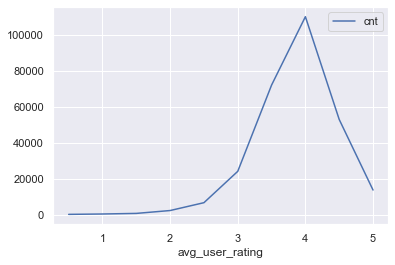

In [28]:
# фильм бывает более или менее популярным - выбросы есть в обе стороны,
# но "средних" фильмов все-таки большинство
histogram = (
    user_ratings
    .select((.5 * sql_func.ceil(2 * sql_func.col('avg_user_rating')))
            .alias('avg_user_rating'))
    .groupBy('avg_user_rating')
    .agg(sql_func.count('avg_user_rating').alias('cnt'))
    .orderBy('avg_user_rating')
    .toPandas()
)
sns.set()
histogram.plot(x='avg_user_rating', y='cnt')
plt.show()

In [31]:
# а может не полусумму, а подберем коэффициенты 
# с помощью линейной регрессии
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

train = (
    VectorAssembler(
        inputCols = ['avg_movie_rating', 'avg_user_rating'],
        outputCol = 'features'
    ).transform(
        ratings
        .join(movie_ratings, 'movieId')
        .join(user_ratings, 'userId')
    )
    .withColumnRenamed('rating', 'label')
    .select('movieId', 'userId', 'label', 'features')
    .cache()
)
linear_model = LinearRegression().fit(train)
stacked_prediction = (
    ratings
    .join(linear_model.transform(train), ['movieId', 'userId'])
    .select('movieId', 'userId', 'prediction')
)
print('ошибка предсказания:', simple_evaluate(stacked_prediction))

ошибка предсказания: 0.8721869117819699


In [33]:
# получаем формулу для предсказания оценки, которую можно использовать для рекомендаций
print(
    '[на сколько пользователь оценит фильм] = {} + {} * [средняя оценка фильма] + {} * [средняя оценка из поставленных этим пользователем]'
    .format(
        round(linear_model.intercept, 2),
        round(linear_model.coefficients[0], 2),
        round(linear_model.coefficients[1], 2)
    )
    )    

[на сколько пользователь оценит фильм] = -2.5 + 0.84 * [средняя оценка фильма] + 0.86 * [средняя оценка из поставленных этим пользователем]
